# Langevin Dynamics of a free Particle


## Theory


#### What is the Langevin equation? What is the dissipation force and what is friction or damping? What is the fluctuation force... how does the fluctuation force depend on temperature and friction?

The langevin equation is:

$$ \dot{p} = -\Delta_qV(q) - \xi p + \sqrt{2\xi k_BTm}\eta (t)$$

Where $V(q)$ is the potential enerqy function at postion $q$, $\Delta_q$ denotes the gradient with respect to the position coordinate, $\xi$ is the collision or friction rate, $T$ is the temperature, and $k_B$ is Boltzmann constant. $\eta$ is a Gaussian white noise with unit variance centered at zero.

The dissipation force is given by the therm $\xi p$ and it depends on the friction. 

The fluctuation force given by $\sqrt{2\xi k_BTm}\eta (t)$ it depends on the temperature. This force represents the impact of the molecules of the solvent on the particle.

#### How does the fluctuation force effectively enter into the equations of motion to be integrated? Is the dimensionality of the term correct?

#### What is a Brownian particle?

Brownian motion is the random motion of a small particle immersed in a fluid. A particle that follows this kind of motion is a brownian particle.

#### What happens to a free particle at nonzero temperature and nonzero friction, if it initially has non-zero velocity?

At $T\ne0$ and $\xi\ne0$ the langevin equation is:

$$ \dot{p} = -\Delta_qV(q) - \xi p + \sqrt{2\xi k_BTm}\eta (t)$$

Which is the standard langevin equation. The trajectory of the particle will be stochastic.

#### What is the fluctuation-dissipation theorem?

The fluctuation-dissipation theorem makes the connection between the spontaneous fluctuations in the system in equilibrium, as described by the non-retarded correlation function S(ω), and the response of the system to external perturbations, as determined by the susceptibility.

#### In the computational experiments you carried out, how did you choose the integration step? Is there any constraint to choose a small or large integration step?



In [1]:
%matplotlib inline

import openmm
import openmm.app as app
import openmm.unit as unit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

## Simulation Set Up

In this first part of the notebook we set up the parameters of the simulation of an argon atom.

In [2]:
def create_topology():
    """ Create a topology with an argon atom.
        
        Returns
        -------
        openmm.app.Topology
    """
    topology = app.Topology()
    chain = topology.addChain()
    residue = topology.addResidue("Ar",chain)
    argon = app.Element.getBySymbol("Ar")
    topology.addAtom("Ar", argon, residue)
    return topology

In [3]:
def create_system():
    """ Create the system with an argon atom.
        
        Returns
        -------
        openmm.System
    """
    system = openmm.System()
    system.addParticle(39.948 * unit.amu) # Ar mass
    return system

In [4]:
def create_simulation_obj(
        system, topology, temperature,
        friction, step, platform_name="CPU"
):
    """ Returns a simulation object.

        Parameters
        -----------
        system : openmm.System
        temperature : float
        friction : float
        step : openmm.unit.Unit
        platform_name : {"CPU", "CUDA"}
    
        Returns
        -------
        openmm.app.Simulation
    """
    temperature = temperature*unit.kelvin
    friction_coeff = friction/unit.picosecond
    
    integrator = openmm.LangevinIntegrator(
        temperature, friction_coeff, step
    )
    
    # Initial position and velocities
    pos = np.zeros((1, 3), np.float32) * unit.angstroms
    vel = np.zeros((1, 3), np.float32) * unit.angstroms/unit.picoseconds
    
    platform = openmm.Platform.getPlatformByName(platform_name)
    
    simulation = app.Simulation(topology, system, integrator, platform)
    
    simulation.context.setPositions(pos)
    simulation.context.setVelocities(vel)
    
    return simulation

## Running the simulation and analyzing it

In [5]:
def run_sim(simulation, step, sim_time, save_time):
    """ Run the simulation while saving the positions, times and velocities
        to numpy arrays
        
        Returns
        -------
        tuple[np.ndarray]
            An array for time, position and velocity.
    """
    n_steps_per_period = int(save_time/step)
    n_periods = int(sim_time/save_time)

    time = np.zeros([n_periods], np.float32) * unit.picoseconds
    position = np.zeros([n_periods, 1, 3], np.float32) * unit.angstroms
    velocity = np.zeros([n_periods, 1, 3], np.float32) * unit.angstroms/unit.picosecond
    
    for ii in tqdm(range(n_periods)):
        simulation.step(n_steps_per_period)
        state = simulation.context.getState(getPositions=True, getVelocities=True)
        
        time[ii] = state.getTime()
        position[ii] = state.getPositions()
        velocity[ii] = state.getVelocities()
    
    return time, position, velocity

In [6]:
def plot_coordinates(time_array, positions):
    """ Plot the x, y and z coordinate against time. Each coordinate in
        a different plot.
    """    

    plt.rcParams['figure.figsize'] = 18, 4

    for ii, axis_label in zip(range(3),['X','Y','Z']):
        plt.plot(time_array, positions[:,0,ii])
        plt.ylabel('{} ({})'.format(axis_label, positions.unit))
        plt.xlabel('time ({})'.format(time_array.unit))
        plt.show()


In [7]:
def plot_2d(positions):
    plt.rcParams['figure.figsize'] = 5, 5

    plt.plot(positions[:,0,0], positions[:,0,1])
    plt.xlabel('X ({})'.format(positions.unit))
    plt.ylabel('Y ({})'.format(positions.unit))
    plt.show()

In [8]:
def prepare_simulation(temperature, friction, step):
    """ Returns a simulation object ready to run a simulation."""
    topology = create_topology()
    system = create_system()
    return create_simulation_obj(
        system, topology, temperature, friction, step
    )


def simulate_and_plot(temperature, friction, step=0.1):
    """ Run a simulation and plot it.
    """
    step = step * unit.picosecond
    simulation = prepare_simulation(temperature, friction, step)
    time, positions, velocities = run_sim(
        simulation,
        step,
        sim_time=2.0 * unit.nanosecond,
        save_time=1.0 * unit.picoseconds
    )

    plot_coordinates(time, positions)
    plot_2d(positions)

100%|██████████| 2000/2000 [00:01<00:00, 1293.79it/s]


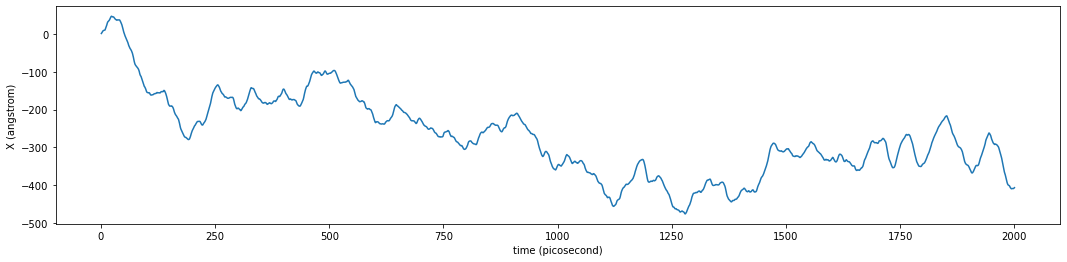

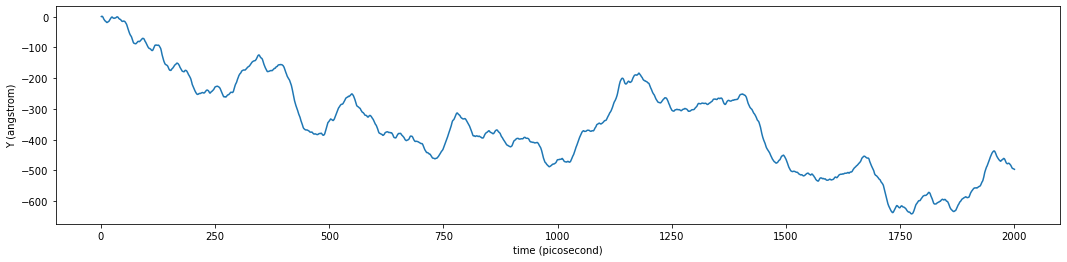

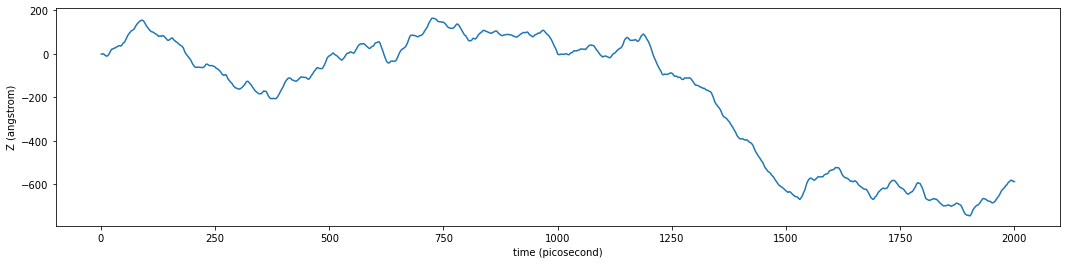

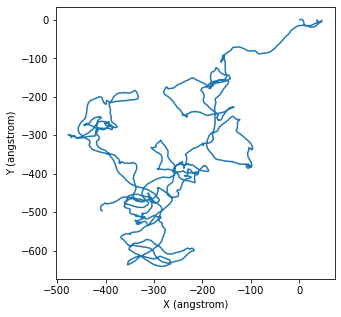

In [9]:
simulate_and_plot(temperature=300, friction=0.1)

## Simulating at different conditions



### Zero friction and temperature

What happens to a free particle at zero temperature and zero friction if it initially has non-zero velocity?

At $T=0$ and $\xi=0$, the langevin equation is:

$$ \dot{p} = -\Delta_qV(q)$$

Which is the standard form of Newton's second law. The differential equation is no longer stochastic.



100%|██████████| 2000/2000 [00:01<00:00, 1285.11it/s]


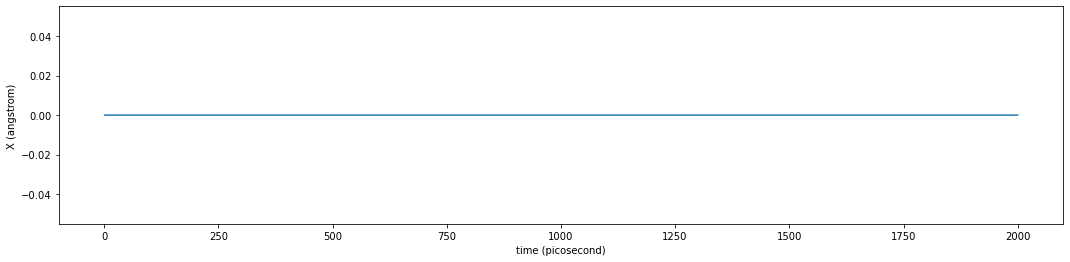

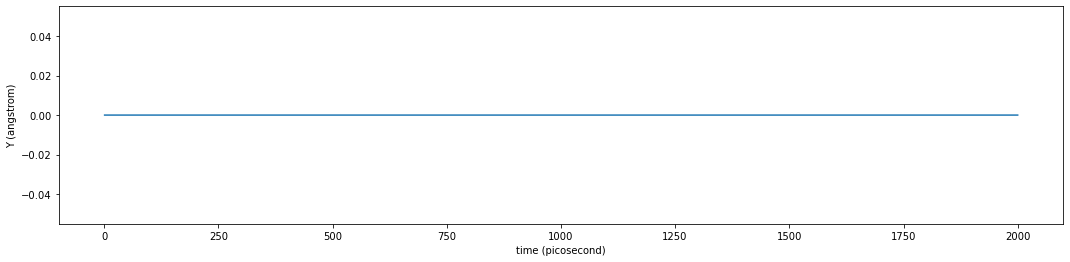

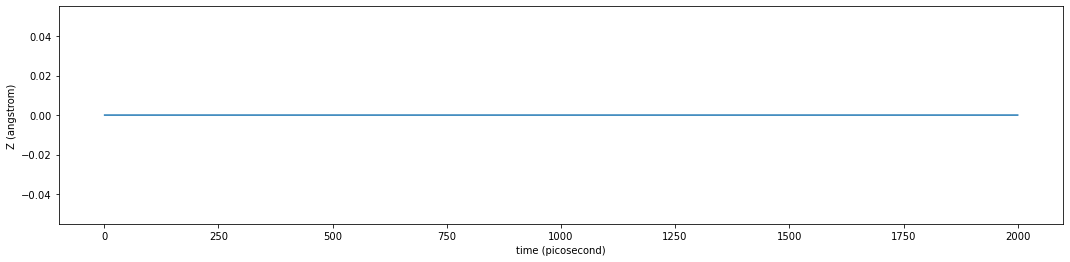

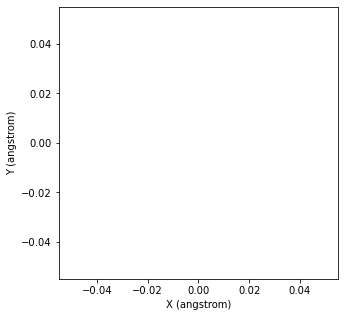

In [10]:
simulate_and_plot(temperature=0, friction=0)

### Zero temperature

What happens to a free particle at zero temperature and non-zero friction, if it initially has non-zero velocity?

At $T=0$ and $\xi\ne0$, the langevin equation is:

$$ \dot{p} = -\Delta_qV(q) - \xi p$$

The viscous force will evantually grow bigger and stop the particle.


100%|██████████| 2000/2000 [00:01<00:00, 1093.31it/s]


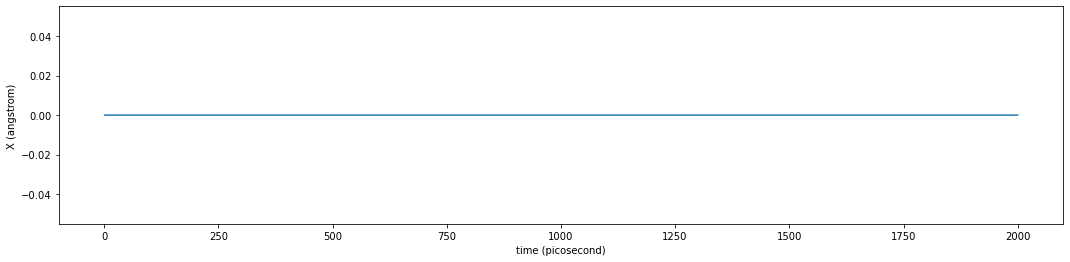

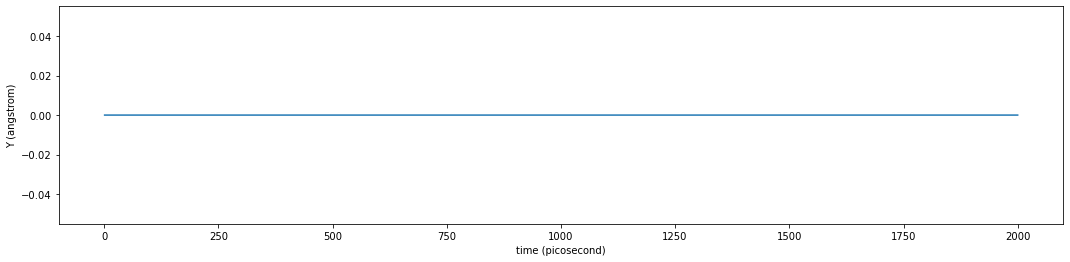

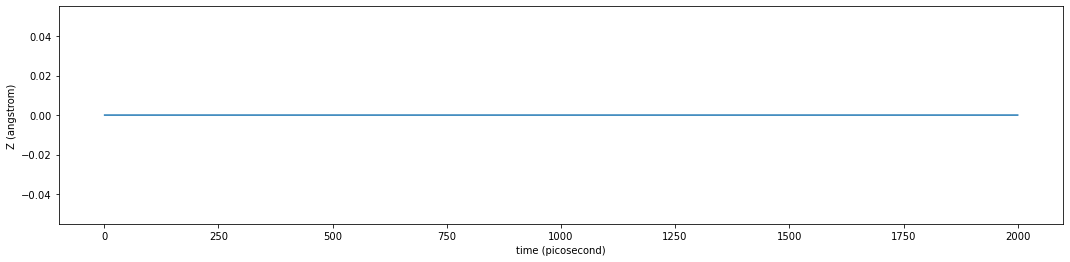

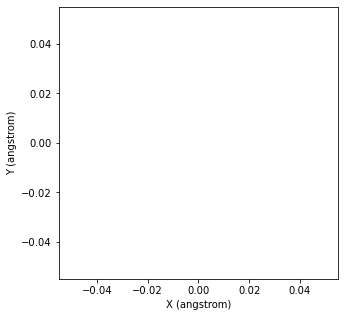

In [11]:
simulate_and_plot(temperature=0, friction=1.0)

### Zero friction

What happens to a free particle at nonzero temperature and zero friction, if it initially has a non-zero velocity?

At $T\ne0$ and $\xi=0$, the langevin equation is:

$$ \dot{p} = -\Delta_qV(q)$$

100%|██████████| 2000/2000 [00:01<00:00, 1251.51it/s]


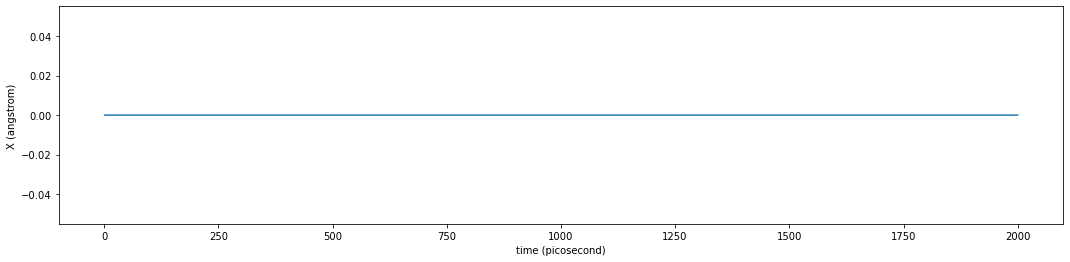

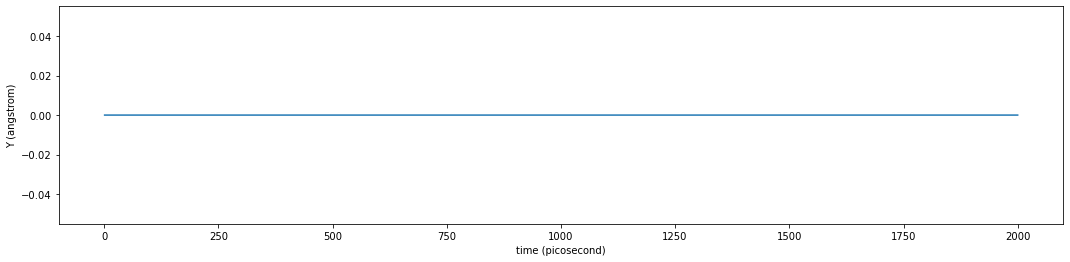

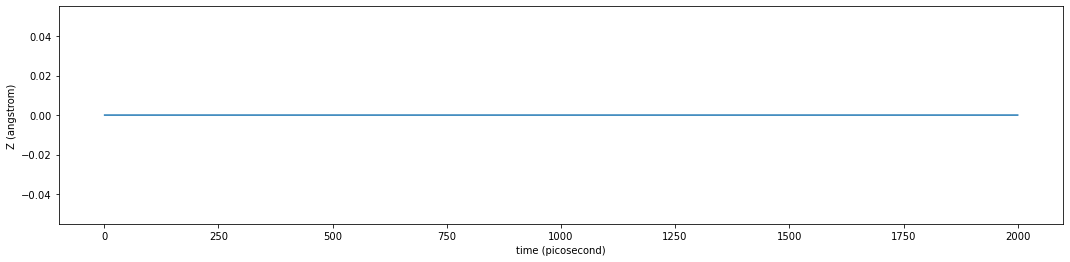

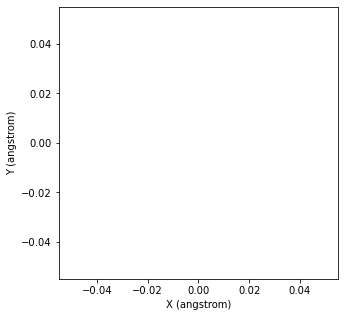

In [12]:
simulate_and_plot(temperature=300, friction=0)

## Kinetic Energy

What is the relationship between the average kinetic energy of a free particle and the temperature, and the kinetic energy given only by the X component of the velocity? Can you corroborate this relationship with a computational experiment? Do you think that this relationship could be used to calculate the temperature of the system by observing the average of the squared velocities of the particles of a system? Can you calculate analytically with statistical mechanics what is the expected kinetic energy of a free particle in a three-dimensional space at temperature T?

$$\langle\frac{1}{2}mv^2 \rangle = \frac{1}{2}k_BT$$


In [13]:
def run_multiple(n_simulations, temperature, friction):
    """ Run multiple simulations with the given temperature
        and friction coefficient.

        Parameters
        ----------
        n_simulations : int
        temperature : float
        friction : float
    """
    step = 0.1 * unit.picoseconds
    sim_time = 2.0 * unit.nanosecond
    save_time = 1.0 * unit.picoseconds

    n_steps_per_period = int(save_time/step)
    n_periods = int(sim_time/save_time)

    # All times will be equal for the simulations
    time = np.zeros([n_periods], np.float32) * unit.picoseconds
    position = np.zeros([n_simulations, n_periods, 1, 3], np.float32) * unit.angstroms
    velocity = np.zeros([n_simulations, n_periods, 1, 3], np.float32) * unit.angstroms/unit.picosecond

    for ii in range(n_simulations):
        simulation = prepare_simulation(temperature, friction, step)
        for jj in range(n_periods):
            simulation.step(n_steps_per_period)
            state = simulation.context.getState(getPositions=True, getVelocities=True)

            time[jj] = state.getTime()
            position[ii, jj, :] = state.getPositions()
            velocity[ii, jj, :] = state.getVelocities()

    return time, np.squeeze(position), np.squeeze(velocity)

In [14]:
def plot_average_kinetic_energy(velocity, time):

    mass = 39.948 * unit.amu
    mean_vel = np.mean(np.sum(np.square(velocity), axis=-1), axis=0)
    ke = mean_vel * mass / 2

    assert ke.shape == time.shape, f"Kinetic energy has shape {ke.shape}"

    plt.rcParams['figure.figsize'] = 18, 4
    plt.plot(time, ke)
    plt.ylabel('Kinetic energy ({})'.format(ke.unit))
    plt.xlabel('time ({})'.format(time.unit))
    plt.show()

In [15]:
all_times, all_positions, all_velocities = run_multiple(
        n_simulations=1000, temperature=300, friction=0.1
)

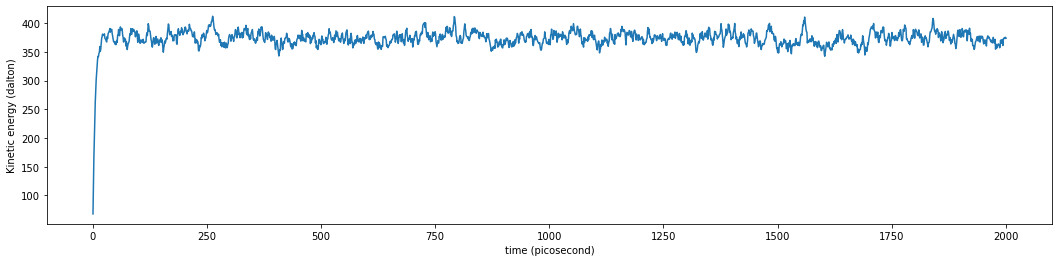

In [16]:
plot_average_kinetic_energy(all_velocities, all_times)

## Diffusion

#### What is the diffusion of a particle, what is its relation with the mean square dispersion of a particle, and with the temperature? Could you perform the appropriate computational experiments to corroborate the relation between the temperature of the system and the mean square distance that a particle has advanced from its initial position in a time t?

Diffusion is defined as the movement of individual molecules of a substance through a semipermeable barrier from an area of higher concentration to an area of lower concentration. The diffusion equation is:

$$ \frac{\partial f}{\partial t} = D\frac{\partial^2 f}{\partial x^2}$$

Where D is the diffussion coefficient.

The diffussion coefficient is related to the mean square displacement of the particle and the temperature by the following relationship:

$$\lambda_x = \sqrt{\langle x^2 \rangle - \langle x^2_0 \rangle} = \sqrt{2Dt}$$

In [17]:
def plot_average_positions(position, time):

    avg_pos= np.mean(np.square(position), axis=0)

    plt.rcParams['figure.figsize'] = 18, 4
    plt.plot(time, avg_pos[:, 0])  # only plot one coordinate
    plt.ylabel('x ({})'.format(unit.angstroms))
    plt.xlabel('time ({})'.format(time.unit))
    plt.show()

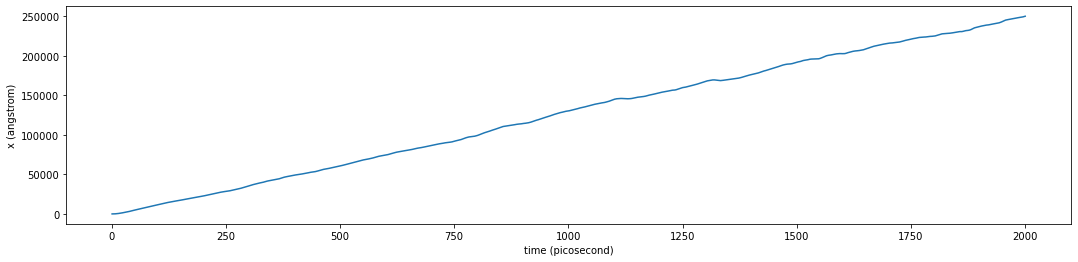

In [18]:
plot_average_positions(all_positions, all_times)